In [393]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py

import matplotlib as mpl
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
from tqdm.auto import tqdm

In [394]:
def read_data(path_dataset):
    data = {}
    time_init =     "Time:  0.00000E+00 y"
    time_final =    "Time:  5.00000E+00 y"
    number_datapoints = 0
    names_of_runs = []

    for file in tqdm(list(os.listdir(path_dataset))):
        try:
            path_data = os.path.join(path_dataset,file)
            if not os.path.isdir(path_data):
                continue
            print(file)
            names_of_runs.append(file)
            filename = os.path.join(path_data,"pflotran.h5") 
            with h5py.File(filename, "r") as f:
                for key, value in f[time_final].items():
                    if not key in data: # and not key=='Material_ID':
                        data[key] = []
                    #if not key=='Material_ID':
                    if key=='Liquid_Pressure [Pa]':
                        data[key].append(np.array(f[time_init]["Liquid_Pressure [Pa]"]))
                    else:
                        data[key].append(np.array(value))
            number_datapoints += 1

        except Exception as e:
            tqdm.write(f"lololololololoo: {e}")

    for key,value in data.items():
        data[key] = np.array(value)

    return data, number_datapoints, names_of_runs

In [395]:
def read_data_df(path_dataset):
    time_init =     "Time:  0.00000E+00 y"
    time_final =    "Time:  5.00000E+00 y"
    names_of_runs = []
    names_of_properties = []
    data = []

    for file in tqdm(list(os.listdir(path_dataset))):
        try:
            path_data = os.path.join(path_dataset,file)
            if not os.path.isdir(path_data):
                continue
            #print(file)
            names_of_runs.append(file)
            filename = os.path.join(path_data,"pflotran.h5") 
            interim_array = []
            with h5py.File(filename, "r") as f:
                for key, value in f[time_final].items():
                    if key=='Liquid_Pressure [Pa]':
                        interim_array.append(np.array(f[time_init]["Liquid_Pressure [Pa]"]))
                    else:
                        interim_array.append(np.array(value))
                names_of_properties = list(f[time_final].keys())
            data.append(interim_array)

        except Exception as e:
            tqdm.write(f"lololololololoo: {e}")
    
    df = pd.DataFrame(data=data, index=names_of_runs, columns=names_of_properties)

    return df

In [509]:
def aligned_colorbar(*args,**kwargs):
    cax = make_axes_locatable(plt.gca()).append_axes("right",size= 0.3,pad= 0.05)
    plt.colorbar(*args,cax=cax,**kwargs)
    
def plot_sample(data, sample_id, view="top"):
    n_dims = len(data)
    fig, axes = plt.subplots(n_dims,1,sharex=True,figsize=(20,3*n_dims))
    plt.figure(figsize= (20,3*n_dims))
    for i,(key,value) in zip(range(n_dims),data.items()):
        plt.sca(axes[i])
        field = value[sample_id]
        if len(field.shape) != 3:
            # no 3D data
            continue
        index = key.find(' [')
        title = key
        if index != -1:
            title = key[:index]
        plt.title(title)
        if view=="topish":
            plt.imshow(field[:,:,-3])
            plt.xlabel("y")
            plt.ylabel("x")
        elif view=="side":
            plt.imshow(field[11,:,::-1].T)
            plt.xlabel("y")
            plt.ylabel("z")
        elif view=="side_hp":
            plt.imshow(field[8,:,::-1].T)
            plt.xlabel("y")
            plt.ylabel("z")
        elif view=="top_hp":
            plt.imshow(field[:,:,8])
            plt.xlabel("y")
            plt.ylabel("x")
        elif view=="top":
            plt.imshow(field[:,:,-1])
            plt.xlabel("y")
            plt.ylabel("x")
        aligned_colorbar(label=key)
    plt.show()

def plot_sample_df(df, run_id, view="top"):
    n_dims = len(df.columns)
    fig, axes = plt.subplots(n_dims+1,1,sharex=True,figsize=(20,3*(n_dims+1)))
    plt.figure(figsize= (20,3*(n_dims+1)))
    for column, (i) in zip(df.columns, range(n_dims)):
        plt.sca(axes[i])
        field = df.at[run_id, column]
        if len(field.shape) != 3:
            # no 3D data
            continue
        index = column.find(' [')
        title = column
        if index != -1:
            title = column[:index]
        plt.title(title)
        if view=="topish":
            plt.imshow(field[:,:,-3])
            plt.xlabel("y")
            plt.ylabel("x")
        elif view=="side":
            plt.imshow(field[11,:,::-1].T)
            plt.xlabel("y")
            plt.ylabel("z")
        elif view=="side_hp":
            plt.imshow(field[8,:,::-1].T)
            plt.xlabel("y")
            plt.ylabel("z")
        elif view=="top_hp":
            plt.imshow(field[:,:,8])
            plt.xlabel("y")
            plt.ylabel("x")
        elif view=="top":
            plt.imshow(field[:,:,-1])
            plt.xlabel("y")
            plt.ylabel("x")
        aligned_colorbar(label=column)
        
    #streamlines
    if view=="side":
        plt.sca(axes[i+1])
        Z, Y = np.mgrid[0:len(field[0,0,:]),0:len(field[0,:,0])]
        U = df.at[run_id,'Liquid Y-Velocity [m_per_y]'][11,:,::-1]
        V = df.at[run_id,'Liquid Z-Velocity [m_per_y]'][11,:,::-1]
        #print(np.shape(Y.T), np.shape(Z.T), np.shape(U.T), np.shape(V.T))
        plt.streamplot(Y, Z, U.T, V.T, density=[2, 0.7])
    elif view=="side_hp":
        plt.sca(axes[i+1])
        Z, Y = np.mgrid[0:len(field[0,0,:]),0:len(field[0,:,0])]
        U = df.at[run_id,'Liquid Y-Velocity [m_per_y]'][8,:,::-1]
        V = df.at[run_id,'Liquid Z-Velocity [m_per_y]'][8,:,::-1]
        #print(np.shape(Y.T), np.shape(Z.T), np.shape(U.T), np.shape(V.T))
        plt.streamplot(Y, Z, U.T, V.T, density=[2, 0.7])
    elif view=="top_hp":
        plt.sca(axes[i+1])
        X, Y = np.mgrid[0:len(field[:,0,0]),0:len(field[0,:,0])]
        U = df.at[run_id,'Liquid Y-Velocity [m_per_y]'][:,:,8]
        V = df.at[run_id,'Liquid X-Velocity [m_per_y]'][:,:,8]
        #print(np.shape(Y.T), np.shape(Z.T), np.shape(U.T), np.shape(V.T))
        plt.streamplot(Y, X, U, V, density=[2, 0.7])
    elif view=="top":
        plt.sca(axes[i+1])
        X, Y = np.mgrid[0:len(field[:,0,0]),0:len(field[0,:,0])]
        U = df.at[run_id,'Liquid Y-Velocity [m_per_y]'][:,:,-1]
        V = df.at[run_id,'Liquid X-Velocity [m_per_y]'][:,:,-1]
        #print(np.shape(Y.T), np.shape(Z.T), np.shape(U.T), np.shape(V.T))
        plt.streamplot(Y, X, U, V, density=[2, 0.7])
    elif view=="topish":
        plt.sca(axes[i+1])
        X, Y = np.mgrid[0:len(field[:,0,0]),0:len(field[0,:,0])]
        U = df.at[run_id,'Liquid Y-Velocity [m_per_y]'][:,:,-3]
        V = df.at[run_id,'Liquid X-Velocity [m_per_y]'][:,:,-3]
        #print(np.shape(Y.T), np.shape(Z.T), np.shape(U.T), np.shape(V.T))
        plt.streamplot(Y, X, U, V, density=[2, 0.7])
        
    plt.show()

<Figure size 1440x1512 with 0 Axes>

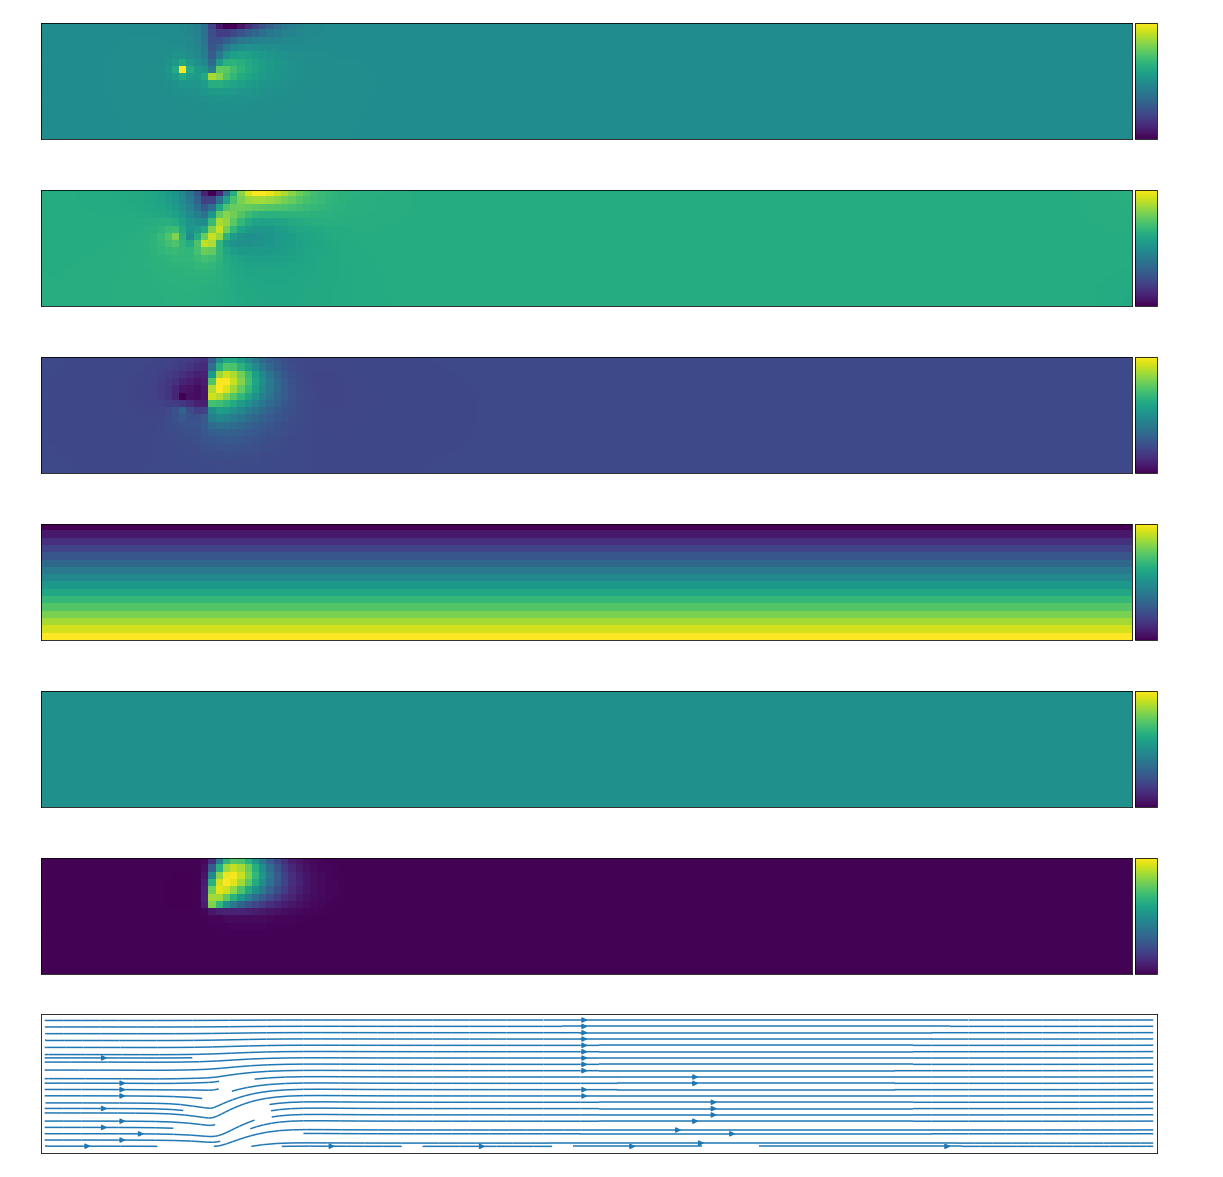

In [511]:
if True:
    plot_sample_df(df,"RUN_1",view="side_hp")
else:
    #streamlines
    run_id = "RUN_1"
    field = df.at[run_id, 'Liquid Y-Velocity [m_per_y]']
    Z, Y = np.mgrid[0:len(field[0,0,:]),0:len(field[0,:,0])]
    U = df.at[run_id,'Liquid Y-Velocity [m_per_y]'][8,:,::-1]
    V = df.at[run_id,'Liquid Z-Velocity [m_per_y]'][8,:,::-1]
    print(np.shape(Y.T), np.shape(Z.T), np.shape(U.T), np.shape(V.T))
    plt.streamplot(Y, Z, U.T, V.T, density=[2,0.5])
        

In [451]:
path_dir = "/home/pelzerja/Development/simulation_groundtruth_pflotran/Phd_simulation_groundtruth/approach2_dataset_generation_simplified"
dataset_name = "dataset_HDF5_test" #dataset_HDF5_uniformly_distributed_data
path_dataset = os.path.join(path_dir, dataset_name)

#data, number_datapoints, names_datapoints = read_data(path_dataset)
#print(data["Liquid_Pressure [Pa]"][0,:,:,:].shape)
#plot_sample(data,2,view="topish")
#print(number_datapoints)

df = read_data_df(path_dataset)
#plot_sample_df(df,"RUN_4", "top_hp")

# print(df)

100%|██████████| 7/7 [00:00<00:00, 51.58it/s]


**Preprocessing**

In [398]:
# find maximum alias hp
# print(np.where(data["Material_ID"]==np.max(data["Material_ID"])))

## data cleaning: cut of edges - to get rid of problems with boundary conditions
def data_cleaning(data):
    for key, (value) in data.items():
        data[key] = data[key][:,1:-1,1:-3,1:-1]
        print(f"{key} :{np.shape(data[key])}")
    return data

def data_cleaning_df(df):
    for label, content in df.items():
        for index in range(len(content)):
            content[index] = content[index][1:-1,1:-3,1:-1]
    return df

df = data_cleaning_df(df)
#plot_sample(df,"RUN_1",view="side_hp")

In [87]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [120]:
## shuffle data along "RUN_"-axis
# is already shuffled from reading-order but whatever
df_shuffled = df.sample(frac=1)

## split data into test and training data
train_size_percent = 0.8
train_size_abs = int(train_size_percent * df.shape[0]) # cuts instead of rounds

df_train = df_shuffled[:train_size_abs]
df_test = df_shuffled[train_size_abs:]

In [121]:
## data normalizing:
# prep data: normalize all input values (vel/pressure) and all output values (temp/vel?), each to its own min,max, std

# scaler-function for a row(=index) in the dataset
def get_max_min(array):
    return np.max(array), np.min(array)

def scale_data_row(data, column, desired_max = 1, desired_min = -1):
    max_list = []
    min_list = []
    for row in data.index:
        max_temp, min_temp = get_max_min(data.at[row, column])
        max_list.append(max_temp)
        min_list.append(min_temp)
    
    max_data = np.max(max_list)
    min_data = np.min(min_list)    
    for row in data.index:
        data_std = (data.at[row,column] - min_data) / (max_data - min_data)
        data.at[row, column] = data_std * (desired_max - desired_min) + desired_min
        #print(row, column)
        #print(np.max(data.at[row, column]), np.min(data.at[row, column]))

    return data
#test = [[[1,2], [1,2]], [[3,3], [3,3]], [[1,2], [1,2]], [[-10,10], [4,4]]]
#test_res = scale_data_row(test)
#print(np.std(test_res))

def scale_data(data):
    for column in data.columns:
        data = scale_data_row(data, column)
    return data

df_train = scale_data(df_train)
df_test = scale_data(df_test)

# just for manuel checking the values
#for column in df_test.columns:
#    for row in df_test.index:
#        print(column, row, np.min(df_test.at[row, column]), np.max(df_test.at[row, column]), np.std(df_test.at[row, column]))
#for column in df_train.columns:
#    for row in df_train.index:
#        print(column, row, np.min(df_train.at[row, column]), np.max(df_train.at[row, column]), np.std(df_train.at[row, column]))

In [168]:
## split data into input and labels
df_train_in = pd.DataFrame(df_train[["Liquid_Pressure [Pa]","Material_ID"]])
df_train_labels = pd.DataFrame(df_train["Temperature [C]"])
df_test_in = pd.DataFrame(df_test[["Liquid_Pressure [Pa]","Material_ID"]])
df_test_labels = pd.DataFrame(df_test["Temperature [C]"])

In [298]:
## parameters
#shuffle_buffer_size = 10
#
### seperate dataset into input data and corresponding output labels
#data_in = {}
#data_labels = {}
#
#data_in['Liquid_Pressure [Pa]'] = data['Liquid_Pressure [Pa]'] #maybe for help in beginning: 'Liquid X-Velocity [m_per_y]', 'Liquid Y-Velocity [m_per_y]', 'Liquid Z-Velocity [m_per_y]']
#data_in['Material_ID'] = data['Material_ID']
#data_labels['Temperature [C]'] = data['Temperature [C]']
#
## create dataset for tf, slice along first dimension: datapoint
## one element := one datapoint (RUN_XYZ); each datapoint is a dictionnary with [0]: input keys="physical properties" (p,pos_hp), values =(x,y,z)-component, [1]:  output keys="physical properties" (T), values =(x,y,z)-component
#tf_data = tf.data.Dataset.from_tensor_slices((data_in, data_labels))
##print(tf_data.element_spec)
#print([elem[0]['Liquid_Pressure [Pa]'][0,0,0].numpy() for elem in tf_data])
#
## shuffle the data
#tf_data = tf_data.shuffle(shuffle_buffer_size)
#print([elem[0]['Liquid_Pressure [Pa]'][0,0,0].numpy() for elem in tf_data])
#
##np.random.seed(seed=1) # TODO just for programming and varification purposes at this point, delete later!

In [154]:
# mnist example to figure out dimensions, format etc
temp = tf.keras.datasets.mnist.load_data(
    path='mnist.npz'
)
for i in (0,1):
    for j in (0,1):
        print(np.shape(temp[i][j]))

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [178]:

def reshape(data):
    data_reshape = []
    for row in data.index:
        temp = []
        for column in data.columns:
            temp.append(data.at[row, column])
        data_reshape.append(temp)

    print(data.columns, data.index)
    data_reshape = np.moveaxis(data_reshape, 1, 4)
    print(np.shape(data_reshape))
    return data_reshape

data_train_in =reshape(df_train_in)
data_train_labels =reshape(df_train_labels)
data_test_in =reshape(df_test_in)
data_test_labels =reshape(df_test_labels)


data_train = (data_train_in, data_train_labels)
data_test = (data_test_in, data_test_labels)
data = (data_train, data_test)
# todo: make tuples for input into tf.data.Dataset

Index(['Liquid_Pressure [Pa]', 'Material_ID'], dtype='object') Index(['RUN_3', 'RUN_2', 'RUN_0', 'RUN_4'], dtype='object')
(4, 2, 18, 146, 14)
(4, 18, 146, 14, 2)
Index(['Temperature [C]'], dtype='object') Index(['RUN_3', 'RUN_2', 'RUN_0', 'RUN_4'], dtype='object')
(4, 1, 18, 146, 14)
(4, 18, 146, 14, 1)
Index(['Liquid_Pressure [Pa]', 'Material_ID'], dtype='object') Index(['RUN_1'], dtype='object')
(1, 2, 18, 146, 14)
(1, 18, 146, 14, 2)
Index(['Temperature [C]'], dtype='object') Index(['RUN_1'], dtype='object')
(1, 1, 18, 146, 14)
(1, 18, 146, 14, 1)


**FCN model definition**

adapted from https://github.com/himanshurawlani/fully_convolutional_network.git
made it 3D

In [281]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Activation, MaxPool3D, Dense, GlobalAveragePooling3D, ReLU, LeakyReLU, UpSampling3D
from tensorflow.keras.utils import to_categorical

In [271]:
print(np.shape(data))
tf_dataloader_train = tf.data.Dataset.from_tensors(data_train)
tf_dataloader_test = tf.data.Dataset.from_tensors(data_test)
# data format: number of sample, x,y,z-dimension, physical property/"channel"

batch_size = 2
# Augment the on the fly during training.
tf_data_train = (
    tf_dataloader_train#.shuffle(len(x_train))
    #.map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

tf_data_test = (
    tf_dataloader_test
    .batch(batch_size)
    .prefetch(2)
)

(2, 2)


In [ ]:
## plotting

tf_data_train = tf_dataloader_train.take(1)
temp_images, temp_labels = list(tf_data_train)[0]
temp_labels =  temp_labels.numpy()
temp_image =  temp_labels[1]
#print(temp_image.shape)
#plt.imshow(np.squeeze(temp_image[:, :, 0, 0]), cmap="gray")

def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    data = np.flip(np.array(data))
    #data = np.flip(np.array(data),axis=2)
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 7 rows and 2 columns for 14 slices of the CT scan.
plot_slices(7, 2, 18, 146, temp_image[:, :, :, 0])

# TODO order of z wrong???


In [267]:
#model = tf.keras.Sequential([
#  tf.keras.layers.Flatten(),
#  tf.keras.layers.Dense(10)
#])
#
#model.compile(optimizer='adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
#              metrics=['accuracy'])
#
##model.fit(tf_data_train, epochs=2)
#

In [ ]:
width, height, depth=[18,146, 14]

def get_model(width=18, height=146, depth=14):
    """Build a 3D convolutional neural network model."""

    inputs = tf.keras.Input((width, height, depth, 2)) #2?

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling3D()(x)
    x = Dense(units=512, activation="relu")(x)
    x = Dropout(0.3)(x)

    outputs = Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = tf.keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=18, height=146, depth=14)
model.summary()

In [318]:
##TRY UNET KYLE
def blockUNet(in_c, out_c, input_shape=(18,146,14), transposed=False, bn=True, activation="relu", size=4, strides=2, pad="same", dropout=0.0):
    input_shape = np.append(input_shape, in_c)
    block = Sequential()
    #block.add(tf.keras.Input(input_shape))
    if activation=="relu":
        block.add(ReLU())
    else:
        block.add(LeakyReLU(alpha=0.2))
    if not transposed:
        block.add(Conv3D(out_c, kernel_size=size, strides=strides, padding=pad, use_bias=True))
    else:
        block.add(UpSampling3D(size=2, data_format="channels_last"))
        block.add(Conv3D(out_c, kernel_size=(size - 1), strides=1, padding=pad, use_bias=True))
    if bn:
        block.add(BatchNormalization(axis=1)) #(out_c))
    if dropout > 0.0:
        block.add(Dropout(dropout)) # inplace=True))
    return block

#UNET Try
channel_exponent = 6
dropout=0.0

channels = int(2**channel_exponent + 0.5)
input_shape = (4, 18, 146, 14, 2) #!! TODO Batchsize!!
model = tf.keras.Sequential([
    Conv3D(filters=channels, kernel_size=4, strides=2, padding="same", use_bias=True,input_shape=input_shape[1:], data_format="channels_last"),
    blockUNet(channels, channels * 2, input_shape[1:-1], transposed=False, bn=True,activation="LeakyReLU",dropout=dropout), #layer2
    #blockUNet(channels * 2, channels * 4, input_shape[1:-1], transposed=False, bn=True,activation="LeakyReLU",dropout=dropout), #layer3
    #blockUNet(channels * 4, channels * 8, input_shape[1:-1], transposed=False, bn=True,activation="LeakyReLU",dropout=dropout, size=4), #layer4
    #blockUNet(channels * 8, channels * 8, input_shape[1:-1], transposed=False, bn=False,activation="LeakyReLU",dropout=dropout, size=2)#, pad="valid"), #layer5
    ])

#TODO : decoder

model.summary()

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_101 (Conv3D)         (None, 9, 73, 7, 64)      8256      
                                                                 
 sequential_67 (Sequential)  (None, 5, 37, 4, 128)     524436    
                                                                 
Total params: 532,692
Trainable params: 532,682
Non-trainable params: 10
_________________________________________________________________


In [317]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    tf_data_train,
    validation_data=tf_data_test,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)


Epoch 1/100


ValueError: in user code:

    File "/home/pelzerja/.local/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/home/pelzerja/.local/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/pelzerja/.local/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/home/pelzerja/.local/lib/python3.8/site-packages/keras/engine/training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "/home/pelzerja/.local/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/pelzerja/.local/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/pelzerja/.local/lib/python3.8/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/pelzerja/.local/lib/python3.8/site-packages/keras/losses.py", line 1807, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/home/pelzerja/.local/lib/python3.8/site-packages/keras/backend.py", line 5173, in binary_crossentropy
        bce = target * tf.math.log(output + epsilon())

    ValueError: Dimensions must be equal, but are 18 and 5 for '{{node binary_crossentropy/mul}} = Mul[T=DT_FLOAT](Cast, binary_crossentropy/Log)' with input shapes: [4,18,146,14,1], [4,5,37,4,128].


In [ ]:
#kernel = 3#(3, 3, 3, 1)
#def FCN_model(input_shape=(20,200,16,1), len_classes=5, dropout_rate=0.2, kernel=3):
#
#    input = Input(shape=input_shape) #2D: (None, None, 3))
#    x = Conv3D(filters=32, kernel_size=kernel, strides=1,padding="same")(input) 
#    #  filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
#    x = Dropout(dropout_rate)(x)
#    x = BatchNormalization()(x)
#    x = Activation('relu')(x)
#
#    # x = tf.keras.layers.MaxPooling2D()(x)
#
#    x = Conv3D(filters=64, kernel_size=kernel, strides=1,padding= "same")(x)
#    x = Dropout(dropout_rate)(x)
#    x = BatchNormalization()(x)
#    x = Activation('relu')(x)
#
#    # x = tf.keras.layers.MaxPooling2D()(x)
#
#    x = Conv3D(filters=128, kernel_size=kernel, strides=2)(x)
#    x = Dropout(dropout_rate)(x)
#    x = BatchNormalization()(x)
#    x = Activation('relu')(x)
#
#    # x = tf.keras.layers.MaxPooling2D()(x)
#
#    x = Conv3D(filters=256, kernel_size=kernel, strides=2)(x)
#    x = Dropout(dropout_rate)(x)
#    x = BatchNormalization()(x)
#    x = Activation('relu')(x)
#
#    # x = tf.keras.layers.MaxPooling2D()(x)
#
#    # x = Conv3D(filters=512, kernel_size=kernel, strides=2)(x)
#    # x = Dropout(dropout_rate)(x)
#    # x = BatchNormalization()(x)
#    # x = Activation('relu')(x)
#
#    # Uncomment the below line if you're using dense layers
#    # x = tf.keras.layers.GlobalMaxPooling2D()(x)
#
#    # Fully connected layer 1
#    # x = tf.keras.layers.Dropout(dropout_rate)(x)
#    # x = tf.keras.layers.BatchNormalization()(x)
#    # x = tf.keras.layers.Dense(units=64)(x)
#    # x = tf.keras.layers.Activation('relu')(x)
#
#    # Fully connected layer 1
#    x = Conv3D(filters=64, kernel_size=1, strides=1)(x)
#    x = Dropout(dropout_rate)(x)
#    x = BatchNormalization()(x)
#    x = Activation('relu')(x)
#
#    # Fully connected layer 2
#    # x = tf.keras.layers.Dropout(dropout_rate)(x)
#    # x = tf.keras.layers.BatchNormalization()(x)
#    # x = tf.keras.layers.Dense(units=len_classes)(x)
#    # predictions = tf.keras.layers.Activation('softmax')(x)
#
#    # Fully connected layer 2
#    x = Conv3D(filters=len_classes, kernel_size=1, strides=1)(x)
#    x = Dropout(dropout_rate)(x)
#    x = BatchNormalization()(x)
#    #x = GlobalMaxPooling3D()(x) #TODO I PERSONALLY EXCLUDED - BACK IN?
#    predictions = Activation('softmax')(x)
#
#    model = tensorflow.keras.Model(inputs=input, outputs=predictions)
#    
#    print(model.summary())
#    print(f'Total number of layers: {len(model.layers)}')
#
#    return model
#

In [69]:
model = FCN_model(input_shape=(20, 200, 16, 1), len_classes=5, dropout_rate=0.2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 20, 200, 16, 1)]  0         
                                                                 
 conv3d_37 (Conv3D)          (None, 20, 200, 16, 32)   896       
                                                                 
 dropout_28 (Dropout)        (None, 20, 200, 16, 32)   0         
                                                                 
 batch_normalization_28 (Bat  (None, 20, 200, 16, 32)  128       
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (None, 20, 200, 16, 32)   0         
                                                                 
 conv3d_38 (Conv3D)          (None, 20, 200, 16, 64)   55360     
                                                             